In [1]:
import pyrosm


import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import CRS, Transformer
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry.multilinestring import MultiLineString

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# reading network.csv.gz file from simulation output folder

dtype = { 'attributeOrigId': str }
out_network = pd.read_csv("../beam_root/output/sf-light/sf-light-0.5k__2023-06-15_16-11-49_obh/network.csv.gz", dtype=dtype)
out_network["str_id"] = out_network['attributeOrigId'].astype(str)
out_network["id"] = pd.to_numeric(out_network["str_id"], errors='coerce').fillna(0).astype('Int64')
# out_network.drop(columns=['str_id', 'attributeOrigId'], inplace=True)
out_network.head(3)

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,fromLocationX,fromLocationY,toLocationX,toLocationY,str_id,id
0,0,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,0,1,551370.872255,4.183680e+06,551296.615289,4.183668e+06,5004035,5004035
1,1,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,1,0,551296.615289,4.183668e+06,551370.872255,4.183680e+06,5004035,5004035
2,10,146.110,12.517089,800.0,1.0,car;walk;bike,7448875,unclassified,8,9,553480.804065,4.180423e+06,553626.820226,4.180434e+06,7448875,7448875


In [3]:
# converting CRS of output network to lat-lon CRS epsg:4326 and creating a geometry for new geopandas data frame

crs_to = CRS.from_epsg(4326) # the lat lon CRS
crs_from = CRS.from_epsg(26910) # sf crs
transformer = Transformer.from_crs(crs_from, crs_to)

def out_row_to_geometry(df_row):
    (from_x, from_y) = transformer.transform(df_row['fromLocationX'], df_row['fromLocationY'])
    (to_x, to_y) = transformer.transform(df_row['toLocationX'], df_row['toLocationY'])
    mls = MultiLineString([[[from_y, from_x], [to_y, to_x]]])
    return mls
    
out_geometry = out_network.apply(out_row_to_geometry, axis=1)
out_geometry.head(2)

0    MULTILINESTRING ((-122.41648369999999 37.79905...
1    MULTILINESTRING ((-122.41732799999998 37.79894...
dtype: object

In [4]:
# creating geopandas data frame

out_network = gpd.GeoDataFrame(out_network, crs='epsg:4326', geometry=out_geometry)
# out_network.drop(columns=['fromLocationX', 'fromLocationY', 'toLocationX', 'toLocationY'], inplace=True)
out_network.head(2)

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,fromLocationX,fromLocationY,toLocationX,toLocationY,str_id,id,geometry
0,0,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,0,1,551370.872255,4.183680e+06,551296.615289,4.183668e+06,5004035,5004035,"MULTILINESTRING ((-122.41648 37.79905, -122.41..."
1,1,75.065,11.175972,1000.0,1.0,car;walk;bike,5004035,residential,1,0,551296.615289,4.183668e+06,551370.872255,4.183680e+06,5004035,5004035,"MULTILINESTRING ((-122.41733 37.79895, -122.41..."


There are 14988 and 7160 lines in filtered network.


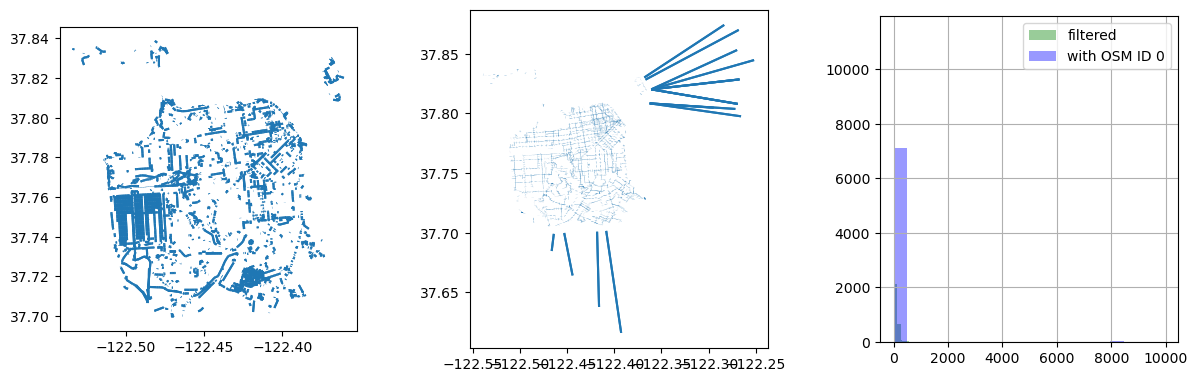

In [5]:
# filtering and plotting

fig, axs = plt.subplots(1, 3, figsize=(13, 5), dpi=100, subplot_kw={'aspect': 1})
fig.tight_layout(pad=5.0)

filtered_1 = out_network[(out_network['id'] > 4 * 10e7)]
filtered_2 = out_network[out_network['id'] == 0]
print(f"There are {len(filtered_1)} and {len(filtered_2)} lines in filtered network.")

filtered_1.plot(ax=axs[0])
filtered_2.plot(ax=axs[1])
filtered_1['linkLength'].hist(ax=axs[2], bins=20, color='green', alpha=0.4, label='filtered')
filtered_2['linkLength'].hist(ax=axs[2], bins=20, color='blue', alpha=0.4, label='with OSM ID 0')

axs[2].legend()

In [6]:
# save the network as shape file

out_network.to_file("output_network.shp")

/tmp/ipykernel_4642/3372521172.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  out_network.to_file("output_network.shp")
